In [6]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.stats import zscore

In [7]:
#model_dir = '/neurospin/dico/jlaval/Output/5_models_FIP_right_3_layer_proj/16-33-05_0/'
#model_dir = '/neurospin/dico/jlaval/Output/SC-sylv_V1_vs_baseline/PreV1_32dims_no_pool_cutin_cutout_only' # score 51%
#model_dir = '/neurospin/dico/jlaval/Output/SC-sylv_left/PreV1_32dims_no_pool' # score 65%
#model_dir = '/neurospin/dico/jlaval/Output/SOr_V1_vs_baseline/V1/'
#model_dir = '/neurospin/dico/jlaval/Output/FIP_cutin_cutout/12-45-14_37/'
#model_dir = '/neurospin/dico/jlaval/Output/V1_FIP/14-06-27_101/'
#model_dir = '/neurospin/dico/jlaval/Output/V1_FIP_right/19-11-38_1'
root = '/neurospin/dico/jlaval/Output/jeanzay/SC-sylv_left_baseline/'
model_dir_list = os.listdir(root)

for model_dir in model_dir_list:
    model_dir = os.path.join(root, model_dir)
    htp_embs = pd.read_csv(os.path.join(model_dir, 'htp_random_embeddings/full_embeddings.csv'))
    htp_embs = htp_embs.drop_duplicates(subset='ID', keep='first')
    htp_embs = htp_embs.reset_index()

    dims = [f'dim{k}' for k in range(1,33)]
    distrib_htp = cosine_distances(htp_embs[dims].to_numpy())
    # sort the indexes by similarity
    sorted_indices_2d = np.unravel_index(np.argsort(distrib_htp.flatten()), distrib_htp.shape)
    distrib_htp -= np.eye(distrib_htp.shape[0])

    #plt.hist(distrib_htp.flatten(), bins=np.linspace(-1,1,100))
    print(np.median(distrib_htp), np.std(distrib_htp), np.quantile(distrib_htp, 0.75), np.quantile(distrib_htp, 0.95))

print('')

root = '/neurospin/dico/jlaval/Output/jeanzay/SC-sylv_left_V1/'
model_dir_list = os.listdir(root)

for model_dir in model_dir_list:
    model_dir = os.path.join(root, model_dir)
    htp_embs = pd.read_csv(os.path.join(model_dir, 'htp_random_embeddings/full_embeddings.csv'))
    htp_embs = htp_embs.drop_duplicates(subset='ID', keep='first')
    htp_embs = htp_embs.reset_index()

    dims = [f'dim{k}' for k in range(1,33)]
    distrib_htp = cosine_distances(htp_embs[dims].to_numpy())
    # sort the indexes by similarity
    sorted_indices_2d = np.unravel_index(np.argsort(distrib_htp.flatten()), distrib_htp.shape)
    distrib_htp -= np.eye(distrib_htp.shape[0])

    #plt.hist(distrib_htp.flatten(), bins=np.linspace(-1,1,100))
    print(np.median(distrib_htp), np.std(distrib_htp), np.quantile(distrib_htp, 0.75), np.quantile(distrib_htp, 0.95)) # the std is influenced by the outliers.

# large difference between V1 and baseline without taking into account UKB

0.06458757423772421 0.1560368649767983 0.1423181982126821 0.3847889726873408
0.06251099585333397 0.1584230398102431 0.1436101048372096 0.4116053633709961
0.06533943732548453 0.16501341931776362 0.14848735413180614 0.4188371418450903
0.06337735450154436 0.15361292200980334 0.14017738566189475 0.3807464855358775
0.07735699055853984 0.1709855474876392 0.16844938654010944 0.44228902739155873

0.05550453248504539 0.14538121032365797 0.12150520741729487 0.3307737194718199
0.055265216940948325 0.1488116514196047 0.12221898795971153 0.33540107462612184
0.05341098428862889 0.15318929019630267 0.12281963519848416 0.35952856564004776
0.059481202091282936 0.15847222099901756 0.13543068406077596 0.37687023025651356


In [74]:
## get the pairs of subjects which are at .75 percentile
percentile = 0.80
idx = int(percentile*sorted_indices_2d[0].shape[0])
idx1, idx2 = sorted_indices_2d[0][idx], sorted_indices_2d[1][idx]
print(idx1, idx2)
# get the associated IDs
print(htp_embs['ID'][idx1], htp_embs['ID'][idx2])
print(f'distance : {distrib_htp[idx1, idx2]}')

216 376
Scan0234 Scan0405
distance : 0.09734601837009682


In [8]:
## use distance to barycenter instead
data = htp_embs[dims].to_numpy()

# Compute Z-scores along each dimension
z_scores = np.abs(zscore(data, axis=0))

# Define a threshold for outlier detection (e.g., Z-score > 3)
outlier_threshold = 2

# Filter out the outliers
filtered_data = data[(z_scores < outlier_threshold).all(axis=1)]
print(f'nb subjects after filtering : {len(filtered_data)}')

# Compute the barycenter (mean) of the remaining data
barycenter = np.mean(filtered_data, axis=0)

print("Barycenter ignoring outliers:", barycenter)

nb subjects after filtering : 392
Barycenter ignoring outliers: [ 11.81522199 -68.31941122  -9.80890742 -13.10448882  19.59186031
 -21.58038861  21.05669165  19.56338028  17.41613816 -23.63654297
 -14.78324309 -16.35906545 -12.96990469  17.00906503  25.56051628
  40.58428777   0.5232933  -11.98693862  21.17580284   1.99294068
  17.28563187  28.80463297  22.43611687 -39.40247789  14.78755179
  -9.08920085  12.19317262   8.10057898  -5.17128324 -34.80164743
   5.29077285   8.05687804]


In [9]:
barycenter_reshaped = barycenter.reshape(1, -1)
cos_dists_htp = cosine_distances(data, barycenter_reshaped)

In [11]:
ukb_embs = pd.read_csv(os.path.join(model_dir, 'ukb40_random_embeddings/full_embeddings.csv')) # use UKB here
ukb_embs = ukb_embs.drop_duplicates(subset='ID', keep='first')
ukb_embs = ukb_embs.reset_index()

In [13]:
# dist between barycenter and ukb
ukb_htp_dist = cosine_distances(ukb_embs[dims].to_numpy(), barycenter_reshaped)

In [16]:
min(ukb_htp_dist)

array([0.07371852])

In [77]:
#ukb_embs = ukb_embs.sample(10000)
distrib_ukb = cosine_distances(ukb_embs[dims].to_numpy())
#flat_distrib = distrib_ukb[~np.eye(distrib_ukb.shape[0], dtype=bool)].flatten()
#plt.hist(flat_distrib, bins=np.linspace(-1,1,100))
#print(np.median(flat_distrib), np.quantile(flat_distrib, 0.25), np.quantile(flat_distrib, 0.05))

In [78]:
# nearest neighboor average distance in UKB
# BEWARE, IT MODIFIES DISTRIB IN PLACE
np.fill_diagonal(distrib_ukb, 1)
nearest = np.min(distrib_ukb, axis=0)
nearest_dist = np.median(nearest)
print(nearest_dist)
print(f'The caracteristic distance is half the distance between nearest neighboors : {nearest_dist / 2}')

0.08586102854463529
The caracteristic distance is half the distance between nearest neighboors : 0.042930514272317644


In [79]:
print(f'median : {np.median(cos_dists_htp)}')
score = 1 - np.sum(cos_dists_htp > nearest_dist / 2) / len(cos_dists_htp)
print(f'proportion of htp scans within the caracteristic distance : {score}')
loose_score = 1 - np.sum(cos_dists_htp > nearest_dist) / len(cos_dists_htp)
print(f'proportion of htp scans within 2 caracteristic distance : {loose_score}')

median : 0.014476251031389165
proportion of htp scans within the caracteristic distance : 0.8116504854368932
proportion of htp scans within 2 caracteristic distance : 0.8990291262135922


In [124]:
pd.DataFrame(nearest).describe()

,0
count,42433.000000
mean,0.926837
std,0.021346
min,0.811586
25%,0.913384
50%,0.928248
75%,0.941944
max,0.999158


# LOOP

In [99]:
root = '/neurospin/dico/jlaval/Output/V1_FIP_right/'
model_dir_list = os.listdir(root)

for epoch in [0,10,20]:

    for model_dir in model_dir_list:

        model_dir = root + model_dir

        htp_embs = pd.read_csv(os.path.join(model_dir, f'htp_random_epoch{epoch}_embeddings/full_embeddings.csv'))
        htp_embs = htp_embs.drop_duplicates(subset='ID', keep='first')
        htp_embs = htp_embs.reset_index()

        dims = [f'dim{k}' for k in range(1,33)]
        distrib_htp = cosine_distances(htp_embs[dims].to_numpy())
        # sort the indexes by similarity
        sorted_indices_2d = np.unravel_index(np.argsort(distrib_htp.flatten()), distrib_htp.shape)
        distrib_htp -= np.eye(distrib_htp.shape[0])

        ## use distance to barycenter instead
        data = htp_embs[dims].to_numpy()

        # Compute Z-scores along each dimension
        z_scores = np.abs(zscore(data, axis=0))

        # Define a threshold for outlier detection (e.g., Z-score > 3)
        outlier_threshold = 2

        # Filter out the outliers
        filtered_data = data[(z_scores < outlier_threshold).all(axis=1)]
        print(f'nb subjects after filtering : {len(filtered_data)}')

        # Compute the barycenter (mean) of the remaining data
        barycenter = np.mean(filtered_data, axis=0)

        barycenter_reshaped = barycenter.reshape(1, -1)
        cos_dists_htp = cosine_distances(data, barycenter_reshaped)

        ukb_embs = pd.read_csv(os.path.join(model_dir, f'ukb40_random_epoch{epoch}_embeddings/full_embeddings.csv')) # use UKB here
        ukb_embs = ukb_embs.drop_duplicates(subset='ID', keep='first')
        ukb_embs = ukb_embs.reset_index()
        distrib_ukb = cosine_distances(ukb_embs[dims].to_numpy())

        np.fill_diagonal(distrib_ukb, 1)
        nearest = np.min(distrib_ukb, axis=0)
        nearest_dist = np.median(nearest)

        print(f'median : {np.median(cos_dists_htp)}')
        score = 1 - np.sum(cos_dists_htp > nearest_dist / 2) / len(cos_dists_htp)
        print(f'proportion of htp scans within the caracteristic distance : {score}')
        loose_score = 1 - np.sum(cos_dists_htp > nearest_dist) / len(cos_dists_htp)
        print(f'proportion of htp scans within 2 caracteristic distance : {loose_score}')

nb subjects after filtering : 381
median : 0.007698329841367757
proportion of htp scans within the caracteristic distance : 0.7475728155339806
proportion of htp scans within 2 caracteristic distance : 0.8796116504854369
nb subjects after filtering : 355
median : 0.00893990334341599
proportion of htp scans within the caracteristic distance : 0.5223300970873787
proportion of htp scans within 2 caracteristic distance : 0.7514563106796117
nb subjects after filtering : 329
median : 0.012344018318872108
proportion of htp scans within the caracteristic distance : 0.6970873786407767
proportion of htp scans within 2 caracteristic distance : 0.8699029126213592
nb subjects after filtering : 355
median : 0.015916613146654157
proportion of htp scans within the caracteristic distance : 0.22718446601941744
proportion of htp scans within 2 caracteristic distance : 0.5242718446601942
nb subjects after filtering : 331
median : 0.016749136335338255
proportion of htp scans within the caracteristic distanc

# LOOP without epochs

In [101]:
root = '/neurospin/dico/jlaval/Output/jeanzay/SC-sylv_left_V1/'
model_dir_list = os.listdir(root)


for model_dir in model_dir_list:

    model_dir = root + model_dir

    htp_embs = pd.read_csv(os.path.join(model_dir, f'htp_random_embeddings/full_embeddings.csv'))
    htp_embs = htp_embs.drop_duplicates(subset='ID', keep='first')
    htp_embs = htp_embs.reset_index()

    dims = [f'dim{k}' for k in range(1,33)]
    distrib_htp = cosine_distances(htp_embs[dims].to_numpy())
    # sort the indexes by similarity
    sorted_indices_2d = np.unravel_index(np.argsort(distrib_htp.flatten()), distrib_htp.shape)
    distrib_htp -= np.eye(distrib_htp.shape[0])

    ## use distance to barycenter instead
    data = htp_embs[dims].to_numpy()

    # Compute Z-scores along each dimension
    z_scores = np.abs(zscore(data, axis=0))

    # Define a threshold for outlier detection (e.g., Z-score > 3)
    outlier_threshold = 2

    # Filter out the outliers
    filtered_data = data[(z_scores < outlier_threshold).all(axis=1)]
    print(f'nb subjects after filtering : {len(filtered_data)}')

    # Compute the barycenter (mean) of the remaining data
    barycenter = np.mean(filtered_data, axis=0)

    barycenter_reshaped = barycenter.reshape(1, -1)
    cos_dists_htp = cosine_distances(data, barycenter_reshaped)

    ukb_embs = pd.read_csv(os.path.join(model_dir, 'ukb40_random_embeddings/full_embeddings.csv')) # use UKB here
    ukb_embs = ukb_embs.drop_duplicates(subset='ID', keep='first')
    ukb_embs = ukb_embs.reset_index()
    distrib_ukb = cosine_distances(ukb_embs[dims].to_numpy())

    np.fill_diagonal(distrib_ukb, 1)
    nearest = np.min(distrib_ukb, axis=0)
    nearest_dist = np.median(nearest)

    print(f'median : {np.median(cos_dists_htp)}')
    score = 1 - np.sum(cos_dists_htp > nearest_dist / 2) / len(cos_dists_htp)
    print(f'proportion of htp scans within the caracteristic distance : {score}')
    loose_score = 1 - np.sum(cos_dists_htp > nearest_dist) / len(cos_dists_htp)
    print(f'proportion of htp scans within 2 caracteristic distance : {loose_score}')

nb subjects after filtering : 383
median : 0.02441281280586527
proportion of htp scans within the caracteristic distance : 0.5941747572815534
proportion of htp scans within 2 caracteristic distance : 0.7883495145631068
nb subjects after filtering : 384
median : 0.023918947306984628
proportion of htp scans within the caracteristic distance : 0.5106796116504855
proportion of htp scans within 2 caracteristic distance : 0.7436893203883495
nb subjects after filtering : 379
median : 0.02408579681540135
proportion of htp scans within the caracteristic distance : 0.6271844660194175
proportion of htp scans within 2 caracteristic distance : 0.8019417475728156
nb subjects after filtering : 392
median : 0.02647879099299222
proportion of htp scans within the caracteristic distance : 0.487378640776699
proportion of htp scans within 2 caracteristic distance : 0.7048543689320388


In [102]:
root = '/neurospin/dico/jlaval/Output/jeanzay/SC-sylv_left_baseline/'
model_dir_list = os.listdir(root)


for model_dir in model_dir_list:

    model_dir = root + model_dir

    htp_embs = pd.read_csv(os.path.join(model_dir, f'htp_random_embeddings/full_embeddings.csv'))
    htp_embs = htp_embs.drop_duplicates(subset='ID', keep='first')
    htp_embs = htp_embs.reset_index()

    dims = [f'dim{k}' for k in range(1,33)]
    distrib_htp = cosine_distances(htp_embs[dims].to_numpy())
    # sort the indexes by similarity
    sorted_indices_2d = np.unravel_index(np.argsort(distrib_htp.flatten()), distrib_htp.shape)
    distrib_htp -= np.eye(distrib_htp.shape[0])

    ## use distance to barycenter instead
    data = htp_embs[dims].to_numpy()

    # Compute Z-scores along each dimension
    z_scores = np.abs(zscore(data, axis=0))

    # Define a threshold for outlier detection (e.g., Z-score > 3)
    outlier_threshold = 2

    # Filter out the outliers
    filtered_data = data[(z_scores < outlier_threshold).all(axis=1)]
    print(f'nb subjects after filtering : {len(filtered_data)}')

    # Compute the barycenter (mean) of the remaining data
    barycenter = np.mean(filtered_data, axis=0)

    barycenter_reshaped = barycenter.reshape(1, -1)
    cos_dists_htp = cosine_distances(data, barycenter_reshaped)

    ukb_embs = pd.read_csv(os.path.join(model_dir, 'ukb40_random_embeddings/full_embeddings.csv')) # use UKB here
    ukb_embs = ukb_embs.drop_duplicates(subset='ID', keep='first')
    ukb_embs = ukb_embs.reset_index()
    distrib_ukb = cosine_distances(ukb_embs[dims].to_numpy())

    np.fill_diagonal(distrib_ukb, 1)
    nearest = np.min(distrib_ukb, axis=0)
    nearest_dist = np.median(nearest)

    print(f'median : {np.median(cos_dists_htp)}')
    score = 1 - np.sum(cos_dists_htp > nearest_dist / 2) / len(cos_dists_htp)
    print(f'proportion of htp scans within the caracteristic distance : {score}')
    loose_score = 1 - np.sum(cos_dists_htp > nearest_dist) / len(cos_dists_htp)
    print(f'proportion of htp scans within 2 caracteristic distance : {loose_score}')

nb subjects after filtering : 365
median : 0.02709724568864158
proportion of htp scans within the caracteristic distance : 0.5436893203883495
proportion of htp scans within 2 caracteristic distance : 0.7514563106796117
nb subjects after filtering : 371
median : 0.025675734892548152
proportion of htp scans within the caracteristic distance : 0.5300970873786408
proportion of htp scans within 2 caracteristic distance : 0.7398058252427184
nb subjects after filtering : 359
median : 0.02617896586593038
proportion of htp scans within the caracteristic distance : 0.5048543689320388
proportion of htp scans within 2 caracteristic distance : 0.7106796116504854
nb subjects after filtering : 378
median : 0.027928631338691057
proportion of htp scans within the caracteristic distance : 0.44660194174757284
proportion of htp scans within 2 caracteristic distance : 0.6873786407766991
nb subjects after filtering : 360
median : 0.03395527486370298
proportion of htp scans within the caracteristic distance 

In [103]:
del distrib_ukb

## Very heavy here

In [ ]:
## TODO: remove the 1 values in the diagonal

In [ ]:
distrib_ukb = distrib_ukb.flatten()

(array([0.00000000e+00, 0.00000000e+00, 1.15800000e+03, 2.79920000e+04,
        2.06908000e+05, 8.06008000e+05, 2.20851000e+06, 4.81467400e+06,
        8.94660400e+06, 1.48220740e+07, 2.24765140e+07, 3.18293100e+07,
        4.25461740e+07, 5.42280620e+07, 6.63428240e+07, 7.83585280e+07,
        8.96483300e+07, 9.96433120e+07, 1.07856128e+08, 1.13911916e+08,
        1.17432034e+08, 1.18379940e+08, 1.16603776e+08, 1.12363570e+08,
        1.05702466e+08, 9.71103060e+07, 8.69079280e+07, 7.56126620e+07,
        6.37233580e+07, 5.18009220e+07, 4.03730360e+07, 2.98480360e+07,
        2.06722540e+07, 1.31197960e+07, 7.36683000e+06, 3.43438800e+06,
        1.16953800e+06, 2.13806000e+05, 3.61530000e+04]),
 array([-1.        , -0.94871795, -0.8974359 , -0.84615385, -0.79487179,
        -0.74358974, -0.69230769, -0.64102564, -0.58974359, -0.53846154,
        -0.48717949, -0.43589744, -0.38461538, -0.33333333, -0.28205128,
        -0.23076923, -0.17948718, -0.12820513, -0.07692308, -0.02564103,
  

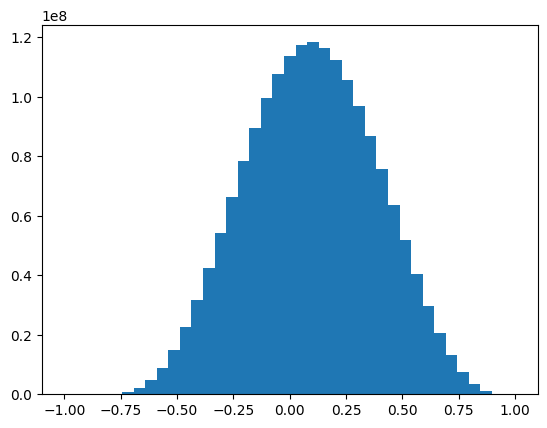

In [23]:
plt.hist(distrib_ukb, bins=np.linspace(-1,1,40))

In [26]:
# AUC
distrib = distrib_ukb.tolist() + distrib_htp.tolist()
labels = [0 for k in range(len(distrib_ukb))] + [1 for k in range(len(distrib_ukb))]

ValueError: operands could not be broadcast together with shapes (1800559489,) (265225,) 